<span style="font-size: 14pt">ФИВТ, АПТ, Курс по машинному обучению, Весна 2018, семинар 7 </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko, </span>
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

# Linear models (Линейные модели)
<h3> Plan </h3>

* **Обзор линейных моделей (25 минут)** 

 - Линейная модель для классификации и регрессии
 - Функции потерь
 - Регуляризация для линейных моделей


* **Градиентный спуск (45 минут)**
 
 - Градиентные методы оптимизации
 - Нахождение градиента простых функций
 - Реализация вариантов SGD


* ** Разбор прикладной задачи  (10 минут)**
 - интеллектуальная рассылка рекомендаций

In [59]:
import sys
import time
import numpy as np
import seaborn as sns
import _pickle as pickle
import pandas as pd
import copy

# from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
import math 
sns.set_context("notebook", font_scale=1.5)

from IPython.display import Image, SVG

from scipy import optimize
import matplotlib.pyplot as plt
# from IPython import display
import random

plt.style.use('ggplot')
%matplotlib inline

<h1 align="center">Warm Up: 3 datasets</h1> 

In [2]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2)
X += np.random.random(X.shape)

datasets = [make_moons(noise=0.1), make_circles(noise=0.1, factor=0.5), (X, y)]

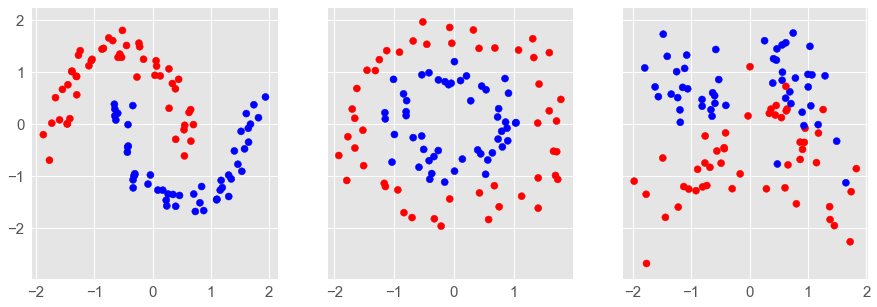

In [7]:
pl = plt.subplots(1, len(datasets), sharex='col', sharey='row', figsize =(15,5))
for i, (X, y) in enumerate(datasets):
    X = StandardScaler().fit_transform(X)
    pl[1][i].scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']))

** Вопрос **: Какая выборка линейно разделима (предполагает использование линейной модели классификации)?

** Вопросы **
 - 1) как выглядит решающее правило для линейных моделей? Какие параметры у линейных моделей?
 - 2) что общего между линейной моделью классификации и регрессии?
 - 3) может ли предсказание линейной модели выходить за область значений обучающей выборки?
 - 4) что такое реуляризация и зачем она нужна?

<h1 align="center"> Обзор линейных моделей </h1>

# Линейные модели для классификации и регрессии

### Классификация
### $$Y = \{+1, -1\},~X\in \mathbf{R}^d$$
### $$y_{predict}(x) = sign(<w, x>) $$ 
### $$margin(x, y) = y \cdot sign(<w, x>)$$
### $$Q(w, X^\ell) = \frac{1}{n} \sum_i^n L(y_i, <w,x_i>) \rightarrow \min_w$$
### $L$ - функция потерь, $Q$ - функция эмпирического риска

### Регрессия
### $$Y = \mathbf{R},~X\in \mathbf{R}^d$$
### $$y_{predict}(x) = <w, x> $$ 
### $$Q(w, X^\ell) = \frac{1}{n} \sum_i^n L(y_i, <w,x_i>) \rightarrow \min_w$$

# Функции потерь:
    - Zero-one loss 
### $$L_i(x, y; w) = sign(1 - y\cdot<w, x>)$$
    - Hinge Loss 
### $$L_i(x, y; w) = max(0, 1 - y\cdot<w, x>)$$
    - Perceptron Loss 
### $$L_i(x, y; w) = max(0, -y\cdot<w, x>)$$
    - Logistic Loss 
### $$L_i(x, y; w) = log(1 + e^{-y\cdot<w, x>})$$
    - Squared hinge Loss
### $$L_i(x, y; w) = \bigl(max(0, 1 - y\cdot<w, x>)\bigr)^2$$
    - Sigmoid Loss 
### $$L_i(x, y; w) = \frac{1}{1 + e^{-y\cdot<w, x>}}$$
![](http://scikit-learn.org/0.15/_images/plot_sgd_loss_functions_001.png = 200x200)
<img src="http://scikit-learn.org/0.15/_images/plot_sgd_loss_functions_001.png", width=60% >

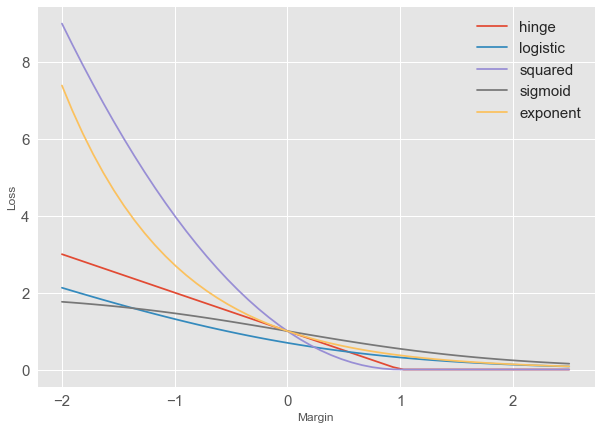

In [86]:
# pylab.rcParams['figure.figsize'] = (10.0, 5.0) 
x = np.linspace(-2, 2.5)
plt.figure(figsize =(10,7))
plt.plot(x, list(map(lambda m: np.max([0, 1 - m]), x)), label='hinge')
plt.plot(x, list(map(lambda m: np.log(1 + math.e**(-m)), x)), label='logistic')
plt.plot(x, list(map(lambda m: (np.max([0, 1 - m]))**2, x)), label='squared')
plt.plot(x, list(map(lambda m: 2*(1 + math.e**(m))**(-1), x)), label='sigmoid')
plt.plot(x, list(map(lambda m: math.e**(-m), x)), label='exponent')
plt.ylabel('Loss')
plt.xlabel('Margin')
plt.legend()

## Регуляризация

<img src="https://raw.githubusercontent.com/shevkunov/ml-mipt-part1/master/2017/seminars/09_linear_models/496/pic/Regularization.PNG" width=60%>

<a href="https://cs.stanford.edu/people/karpathy/svmjs/demo/">** Демо: Регуляризация делает решение более устойчивым **</a>

** Пример использование регуляризации для задачи классификации текстов **
    * see TextClassification.ipynb

---------
<h1 align="center">Градиентный спуск</h1> 

** Вопросы **
* Что такое градиентный спуск (Gradient Descent)?
* Как обновляются веса в методе первого порядка?
* Какие недостатки у простого GD (метод первого порядка)?
* Какие вы знаете методы второго порядка?

<img src="https://raw.githubusercontent.com/shevkunov/ml-mipt-part1/master/2016/seminars/05_linear/img/conv.jpg" width=60%>

## Идея градиентных методов
<img src="http://upload.wikimedia.org/wikipedia/commons/f/ff/Gradient_descent.svg" width="30%">

## Обновление весов в методе первого порядка
## $$w_{k+1} = w_k - \nabla Q(w_k, X^\ell)= w_k - \nabla \sum_i L(w_k, x_i)$$

## Main Problems of gradient method
* Multicollinearity
* Scaling problem
* Plateau
* Zig-zagging

### Plateau
<img src="http://upload.wikimedia.org/wikipedia/commons/6/60/Banana-SteepDesc.gif" width="40%">

### Zig-zagging
<img src="http://upload.wikimedia.org/wikipedia/commons/7/79/Rosenbrock.png" width="40%">

## Методы второго порядка
### Нютон (HF, BFGS)
## $$w_{k+1} = w_k - \nabla^2 Q(w_k) \nabla Q(w_k)$$

Методы второго порядка -- намного быстрее, но как правило дорогие т.к. требуют хранения гессиана.
Некоторые методы второго порядка лишены этого недостатка. При необходимости можно использовать BFGS или HF Newton. 

# Нахождение градиента простых функций
## $$         \nabla_x \langle a, x \rangle = a.     $$
## $$         \nabla_x \|x\|_2^2 = 2 x.     $$
## $$         \nabla_x \langle Ax, x \rangle = (A + A^T) x, $$
### $where ~ A \in R^{d \times d}$
## $$         \nabla_x \|Ax + b\|_2^2 = 2 A^T (Ax + b).     $$

**Задача 1** Найти производные приведенных функций по $w$, в матричной форме 
### $$Q(w) = \sum_i log(1+e^{-y_i <x_i, w>})$$

**Задача 2** Найти производные приведенных функций по $w$, в матричной форме 
### $$Q(w) = \sum_i \frac{2}{1+e^{y_i <x_i, w>}}$$

# Расчёт компонент для обновления весов

In [123]:
def sigmoid(x):
    return 2 * (1 + np.exp(x)) ** (-1)

def exponent(x):
    return np.exp(-x)

def loss(X_train, w, Y_train, func=sigmoid):
    return [func(sum(X_train[idx] * w) * Y_train[idx]) for idx in range(len(X_train))]

def emprisk(X_train, w, Y_train, func=sigmoid):#we want to minimize it
    return sum(loss(X_train, w, Y_train, func))

def grad_sigmoid(x):
    return %%Реализовать%%

def grad_exponent(x):
    return -exponent(x)

def grad_loss(X_train, w, Y_train, func=grad_sigmoid):
    return [%%Реализовать%% for idx in range(len(X_train))]

def grad_emprisk(X_train, w, Y_train, func=grad_sigmoid):
    answ = sum(grad_loss(X_train, w, Y_train, func)).astype(np.double)
    return answ / len(X_train)

---------
<h1 align="center"> Метод стохастического градиента</h1> 

** Вопросы **
* В чём преимущество SGD перед GD?
* Какие недостаки у SGD, помимо проблем со сходимостью? Как их можно устранить?

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

In [24]:
iris = datasets.load_iris()
cv_strategy = ShuffleSplit(n_splits=150, test_size=0.2, random_state=33)

In [283]:
SGDClassifier(penalty='l2', alpha=0.1)

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [39]:
estimators = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    SGDClassifier(max_iter=5, tol=0.1, penalty='l2', alpha=0.1),
    SGDClassifier(max_iter=20, tol=0.1),
    SGDClassifier(max_iter=100, tol=0.1),
    SGDClassifier(max_iter=1000, tol=0.1),
    SGDClassifier(max_iter=5000, tol=0.1),
    SGDClassifier(max_iter=10000, tol=0.1),
    SGDClassifier(max_iter=100000, tol=0.1),
]

for estimator in estimators:
    %time scoring = cross_val_score(estimator, iris.data, iris.target, scoring='accuracy', cv=cv_strategy)
    print ('%.3lf' % scoring.mean(), '%.4lf' % scoring.std())

0.962 0.0287
0.949 0.0360
0.934 0.0413


C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:444: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:444: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:444: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:444: ConvergenceWarning: Maximum number of iteration reached before 

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:444: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:444: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:444: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:444: ConvergenceWarning: Maximum number of iteration reached before 

0.692 0.1433
0.692 0.1612
0.672 0.1668
0.685 0.1765
0.691 0.1634
0.719 0.1569
0.668 0.1666


In [27]:
estimator = SGDClassifier(max_iter=10000, tol=0.1).fit(iris.data, iris.target)
print (estimator.coef_)
print (estimator.classes_)

[[  1.93236715e+01   4.27881297e+01  -6.90131125e+01  -3.24361629e+01]
 [  2.12632896e+01  -1.56973108e+02  -1.06541417e-13  -9.63101939e+01]
 [ -1.22355632e+02  -1.04631218e+02   1.91538022e+02   1.59519726e+02]]
[0 1 2]


## Реализация градиентных методов

### Gradient Descent

In [124]:
# Инциализируем веса
w = [0]*(iris.data.shape[1])
emprisk(X_train, w, Y_train, func=sigmoid)

100.0

In [125]:
# один шаг градиентного спуска
newW = w - 0.001*grad_emprisk(X_train, w, Y_train, grad_sigmoid)
# w = newW
newW

array([ 0.003252 ,  0.001487 ,  0.0026235,  0.000913 ])

In [99]:
def gradientDescent(X_train, Y_train, w=None, func=sigmoid, grad_Func=grad_sigmoid, p=lambda x : 0.001, N=9000, delta=sys.float_info.epsilon):
    cTime = time.time()
    cur = copy.copy(w)
    if w == None:
        if len(X_train) > 0:
            cur = np.array([0 for x in range(len(X_train[0]))], dtype=np.double)
        else:
            return -1

    for t in range(1, N + 1):
        gER = %%Реализовать%%
        prev = cur
        cur = cur - p(t) * gER
        if sum(abs(prev - cur)) <= delta:
            if t == 1:
                print ("Gradient Descent has converged in 1 step!")
            else:
                print ("Gradient Descent has converged in", t, "steps!")
            print ("for ", time.time() - cTime, " seconds.")
            return cur
    print ("Gradient Descent has worked", t, "steps!")
    print ("for ", time.time() - cTime, " seconds.")
    return cur

In [177]:
print ("Func: sigmoid")
newW = gradientDescent(X_train, Y_train, p=lambda x: 0.025, delta=5 * 1e-3)
emprisk(X_train, newW, Y_train)

Func: sigmoid
Gradient Descent has converged in 46 steps!
for  0.045621633529663086  seconds.


32.449581881902589

In [120]:
from scipy.stats import gaussian_kde

def plot_loss_density(loss_values, bins=100, label=''):
    plt.figure(figsize=(17, 4))
    xs = np.linspace(min(loss_values), max(loss_values), bins)
    density = gaussian_kde(loss_values, bw_method=0.04)
    plt.plot(xs, density(xs), linewidth=2.5, color='green')
    plt.scatter(loss_values, np.zeros(len(loss_values)), s=40, alpha=0.15)
    plt.title('Плотность ошибок на обучающей выборке'+ label)

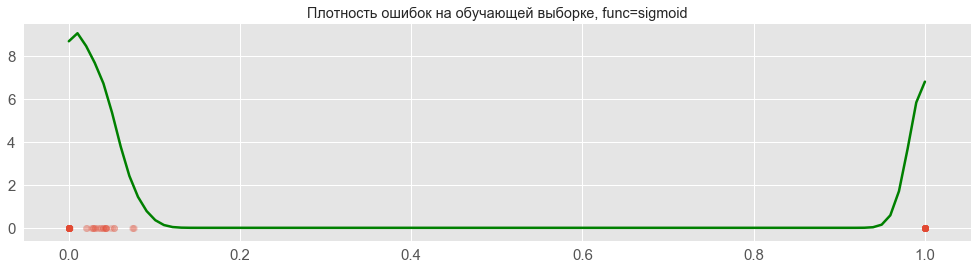

In [178]:
ls = loss(X_train, newW, Y_train, func=sigmoid)
plot_loss_density(loss_values = ls, label=', func=sigmoid')

Func: exponent
Gradient Descent has converged in 150 steps!
for  0.08623194694519043  seconds.
38.0708647684


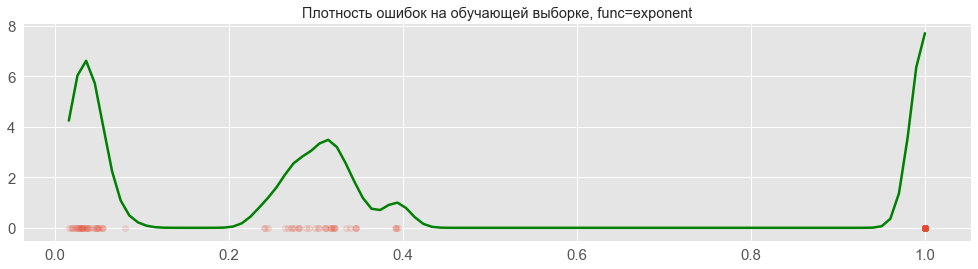

In [179]:
# Exponent loss
print ("Func: exponent")
newW = gradientDescent(X_train, Y_train, p=lambda x: 0.0009, func=exponent, grad_Func=grad_exponent, delta=1 * 1e-3)
print(emprisk(X_train, newW, Y_train, func=exponent))
plot_loss_density(loss(X_train, newW, Y_train), label=', func=exponent')

### Steepest GD
## $$\eta_t = \arg\min\limits_{\eta>0} L \left(x_t - \eta \nabla L(x_t)\right)$$

In [271]:
def steepestGradientDescent(X, Y, w=None, func=sigmoid, grad_Func=grad_sigmoid, N=8192, 
                            delta=sys.float_info.epsilon, internalDelta=sys.float_info.epsilon, internalN=1024, p=lambda x: 1,
                            internalP=lambda x: 1):
    cTime = time.time()
    cur = copy.copy(w)
    if w == None:
        if len(X) > 0:
            cur = np.array([0 for x in range(len(X[0]))], dtype=np.double)
        else:
            return -1

    prev = np.inf
    for t in range(1, N + 1):
        par = p(t)
        gER = grad_emprisk(X, cur, Y, grad_Func)
        check = sum(abs(prev - cur))
        if check > delta * 15:
            for x in range(1, internalN + 1):
                newest = cur - par * gER
                gradByPar = %%Реализовать%%
                if abs(gradByPar) <= internalDelta:
                    break
                par = %%Реализовать%%
         
        prev = cur
        cur = cur - par * gER
        if check <= delta:
            if t == 1:
                print ("Steepest Gradient Descent has converged in 1 step!")
            else:
                print ("Steepest Gradient Descent has converged in", t, "steps!")
            print ("for ", time.time() - cTime, " seconds.")
            return cur
    print ("Steepest Gradient Descent has worked", t, "steps!")
    print ("for ", time.time() - cTime, " seconds.")
    return cur

Func: sigmoid
Steepest Gradient Descent has converged in 3 steps!
for  0.008020639419555664  seconds.
31.0215781976


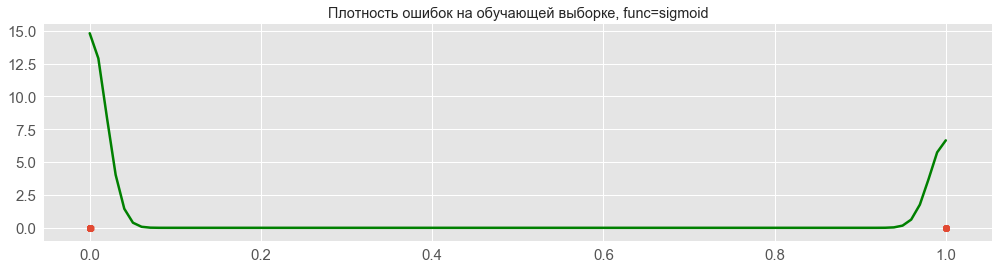

In [259]:
# sigmoid loss
print ("Func: sigmoid")
newW = steepestGradientDescent(X_train, Y_train, func = sigmoid, grad_Func= grad_sigmoid, p=lambda x: 0.025, internalP=lambda x: 0.02, internalN=2, internalDelta=0.01, delta=1e-2)
print(emprisk(X_train, newW, Y_train, func=sigmoid))
plot_loss_density(loss(X_train, newW, Y_train, func=sigmoid), label=', func=sigmoid')

Func: exponent
Steepest Gradient Descent has converged in 3 steps!
for  0.004509449005126953  seconds.
31.0062306795


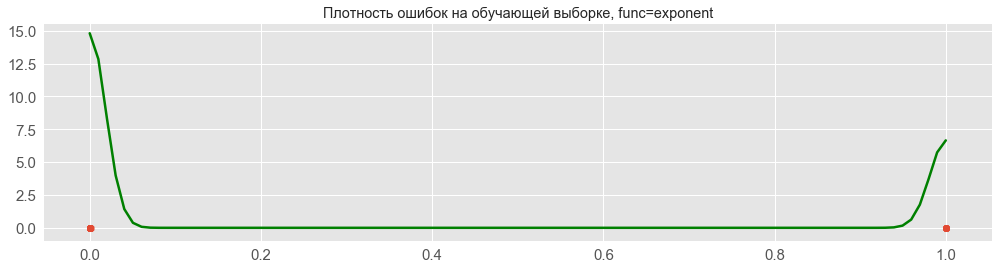

In [266]:
print ("Func: exponent")
newW = steepestGradientDescent(X_train, Y_train, func = exponent, grad_Func= grad_exponent, p=lambda x: 0.025, internalP=lambda x: 0.02, internalN=2, internalDelta=0.01, delta=1e-2)
print(emprisk(X_train, newW, Y_train, func=exponent))
plot_loss_density(loss(X_train, newW, Y_train), label=', func=exponent')

### Newton approach
## $$w_{k+1} = w_k - \nabla^2 L(w_k,x_i) \nabla L(w_k, x_i)$$

In [279]:
def doubleGradOfsigmoid(x):
    return sigmoid(x) * (sigmoid(x) - 1) * (sigmoid(x) / 2 - 1)

def doubleGradOfemprisk(X, w, Y, func=doubleGradOfsigmoid):
    return np.matrix(sum([func(sum(X[idx] * w) * Y[idx]) * np.matrix(X[idx]).T * np.matrix(X[idx]) for idx in range(len(X))]))

def grad_Quadr(x):#quadr = (1 - x)^2 * I{x < 1}
    if x > 1:
        return 0
    else:
        return -2 * (1 - x)

def doubleGradOfQuadr(x):
    if x > 1:
        return 0
    else:
        return 2

def newtonMethod(X, Y, w=None, grad_Func=grad_Quadr, doubleGradOfFunc=doubleGradOfQuadr, N=1024, delta=sys.float_info.min, p=lambda x: 1):
    newW = copy.copy(w)
    if w == None:
        if len(X) > 0:
            newW = np.array([0 for x in range(len(X_train[0]))], dtype=np.double)
        else:
            return -1
    for t in range(1, N):
        tmpW = copy.copy(newW)
        inversed = doubleGradOfemprisk(X = X, w=newW, Y=Y, func=doubleGradOfFunc).I
        transposed  = np.matrix(grad_emprisk(X, newW, Y, grad_sigmoid)).T
        newW = %%Реализовать%%
        print(abs(tmpW - newW))
        if sum(abs(tmpW - newW)) <= delta:
            if t == 1:
                print( "Gradient Descent has converged in 1 step!")
            else:
                print ("Gradient Descent has converged in", t, "steps!")
            return newW
    return newW

In [ ]:
print ("Func: sigmoid")
newW = newtonMethod(X = X_train, Y= Y_train, N=64, p=lambda x: 7.375 * 1e+2)
print(emprisk(X_train, newW, Y_train, func=sigmoid))
plot_loss_density(loss(X_train, newW, Y_train, func=sigmoid), label=', func=sigmoid')

In [ ]:
print ("Func: exponent")
newW = newtonMethod(X_train, Y_train, N=16, p=lambda x: 1e+20)
print(emprisk(X_train, newW, Y_train, func=exponent))
plot_loss_density(loss(X_train, newW, Y_train), label=', func=exponent')

## Stochastic Gradient Descent

In [180]:
import random

def stochasticGradientDescent(X_train, Y_train, w=None, l=0.25, p=lambda x: 0.001, N=9000, funcRisk=emprisk, func=sigmoid, grad_Func=grad_sigmoid, deltaQ=sys.float_info.epsilon, deltaW=sys.float_info.epsilon):
    cTime = time.time()
    newW = copy.copy(w)
    if w == None:
        if len(X_train) > 0:
            newW = np.array([0 for x in range(len(X_train[0]))], dtype=np.double)
        else:
            return -1

    q = funcRisk(X_train, newW, Y_train, func)
    tmpW = []
    tmpQ, t = 0, 0
    while not t or (sum(abs(tmpW - newW)) > deltaW and abs(q - tmpQ) > deltaQ and t < N):
        tmpQ = q
        tmpW = copy.copy(newW)
        idx = random.randint(0, len(X_train) - 1)
        e = loss(X_train, newW, Y_train, grad_Func)[idx]
        newW = %%Реализовать%%
        q = (1 - l) * q + l * e
        t += 1
        #print emprisk(X_train, newW, Y_train, func), sum(abs(tmpW - newW))
        if sum(abs(tmpW - newW)) <= deltaW or abs(q - tmpQ) <= deltaQ:
            if t == 1:
                print ("Stochastic Gradient Descent has converged in 1 step!")
            else:
                print ("Stochastic Gradient Descent has converged in", t, "steps!")
            print ("for ", time.time() - cTime, " seconds.")
            return newW
    print ("Stochastic Gradient Descent has worked", t, "steps!")
    print ("for ", time.time() - cTime, " seconds.")
    return newW

Func: sigmoid
Stochastic Gradient Descent has converged in 2 steps!
for  0.005012035369873047  seconds.
97.7778351864


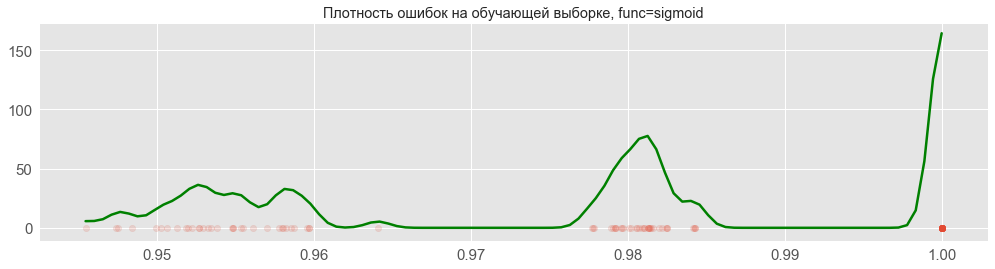

In [270]:
# sigmoid loss
print ("Func: sigmoid")
newW = stochasticGradientDescent(X_train, Y_train, func=sigmoid, grad_Func=grad_sigmoid, p = lambda x: 0.0006, deltaW=1e-10, deltaQ=1e-10)
print(emprisk(X_train, newW, Y_train, func=sigmoid))
plot_loss_density(loss(X_train, newW, Y_train, func=sigmoid), label=', func=sigmoid')

Func: exponent
Stochastic Gradient Descent has converged in 13 steps!
for  0.019047260284423828  seconds.
60.6278641708


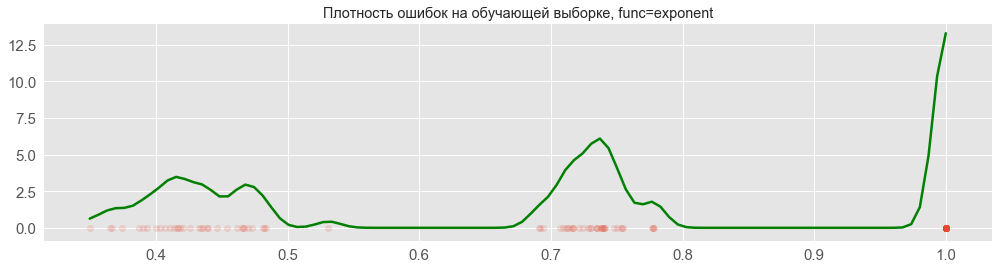

In [237]:
# Exponent loss
print ("Func: exponent")
newW = stochasticGradientDescent(X_train, Y_train, p=lambda x: 0.0009, func=exponent, grad_Func=grad_exponent, deltaW=1e-10, deltaQ=1e-10)
print(emprisk(X_train, newW, Y_train, func=exponent))
plot_loss_density(loss(X_train, newW, Y_train), label=', func=exponent')


### SAG
$$w^{(t+1)}=w^{(t)}-\frac{\eta_t}{\ell} \nabla \left( (\ell-1)\cdot Q(w^{(t-1)},X^\ell\setminus \{x_i\}) + Q(w^{(t)},x_i)\right)$$

In [ ]:
def stochasticAverageGD(X_train, Y_train, w=None, l=0.25, p=lambda x: 0.001, N=9000, funcRisk=emprisk, func=sigmoid, grad_Func=grad_sigmoid, deltaQ=sys.float_info.epsilon, deltaW=sys.float_info.epsilon):
    cTime = time.time()
    newW = copy.copy(w)
    if w == None:
        if len(X_train) > 0:
            newW = np.array([0 for x in range(len(X_train[0]))], dtype=np.double)
        else:
            return -1

    q = funcRisk(X_train, newW, Y_train, func)
    prev_e, tmpW = []
    prev_e = []
    tmpQ, t = 0, 0
    while not t or (sum(abs(tmpW - newW)) > deltaW and abs(q - tmpQ) > deltaQ and t < N):
        tmpQ = q
        tmpW = copy.copy(newW)
        idx = random.randint(0, len(X_train) - 1)
        e = loss(X_train, newW, Y_train, grad_Func)[idx]
        newW = %%Реализовать%%
        q = (1 - l) * q + l * e
        t += 1
        #print emprisk(X_train, newW, Y_train, func), sum(abs(tmpW - newW))
        if sum(abs(tmpW - newW)) <= deltaW or abs(q - tmpQ) <= deltaQ:
            if t == 1:
                print ("Stochastic Gradient Descent has converged in 1 step!")
            else:
                print ("Stochastic Gradient Descent has converged in", t, "steps!")
            print ("for ", time.time() - cTime, " seconds.")
            return newW
    print ("Stochastic Gradient Descent has worked", t, "steps!")
    print ("for ", time.time() - cTime, " seconds.")
    return newW

### Выводы

<h1 align="center">Разбор прикладной задачи: Интеллектуальная рекомендация мультфильмов </h1>  

<img src="http://i.sunnymagadan.su/u/8b/cd1a48083611e6b173ce2ebbcb9526/-/maxresdefault.jpg", width=40%>
** Формулировка **
 * С вами общаются представители фанатского сайта с мультсериалами <a href="https://www.foxtv.ru/">fox</a>. Они хотят делать рассылки писем для своих пользователей, и для этого им нужна помощь человека, знающего ML.

** Бизнес-ограничения **
 * Рассылки делаются только зарегистрированным пользователям
 * Нужно блюсти возрастные ограничения (6+, 12+, 16+, 18+ и т.д.). Возраст указывается при регистрации
 * Если человек смотрит какой-то сериал, не нужно предлагать следующие серии этого сериала

** Как мерить бизнес-результат **
 * 1. Конверсия письма в переход на слайд
 * 2. Средняя возвращаемость (через сколько времени человек снова заходит на сайт и какая доля людей возвращается)
 * 3. Среднее время на сайте и среднее число просмотренных минут серий
 * 4. Время на сайте после перехода
 * 5. Обычно такие сайты живут за счёт рекламы, можно смотреть на число кликов по рекламным блокам и число просмотров рекламных вставок

** Вопросы: **
 1. Как поставить задачу машинного обучения? 
 2. Какие признаки следует добавить в обучающую выборку?
 3. Какое взять решающее правило?
 4. Как поставить эксперимент, подтверждающий, что построенная модель принесёт пользу?

<h1 align="center">Заключение</h1>  

**SGD**: 
*Достоинства:
    - Быстрые
    - Работают
    - Интерпретируемы
    - Применимы к большим данным
    - Можно обучать онлайн
* Недостатки:
    - Плохая обобщающая способность
        - требуется регуляризация
        - SAG
    - Вопросы сходимости
        - игра с параметрами сходимости, масштабирование признаков

** Обратная связь ** 
  * оцените <a href="https://goo.gl/forms/kYZuyAQLuwo8szce2"> семинар </a>
  * оставьте <a href="https://goo.gl/forms/zeZiu1fSgrpPGp6T2"> отзыв </a> о лекции